<br>

# Malaria Detection using Image Classification

<img src="images/malaria-mosquito-antibiotics-resistant-epidemic-761253.jpg" style="width: 500px;"/>

<br>


## Introduction

<br>
This data was downloaded through Kaggle, which took the dataset from the official NIH Website (links below). The NIH page hosts a repository of segmented cell images from thin blood smear slide samples from the Malaria Screener research activity. These cell images have been labelled into two categories: ‘Parasitized’ and ‘Uninfected’. <br><br>
The aim of this project is to create a system which can automate the detection of infected cells, with the aim to reduce the burden for miscoscropists in resource-constrained regions and improve diagnostic accuracy. It is also worth noting that, although the context here is very specific (cell images), the techniques used here are applicable to a number of image classification problems which has a sufficient dataset.

__Dataset Links:__<br>
Kaggle link: https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria <br>
NIH link: https://ceb.nlm.nih.gov/repositories/malaria-datasets/<br><br>


### Project Outline

__1.	Reading and understanding the data__ <br>Of course, our data here is in the form of images and, therefore, there is little we can do in terms of data exploration. Nevertheless, it is still important to view a number of sample images from each image class to provide context to the problem we are trying to solve.
<br><br>
__2.	Data pre-processing__ <br> This includes rescaling of the images to a consistent image size and pixel value range. We must then split the data into a training set and a validation set.
<br><br>
__3.	Building a Convolutional Neural Network (CNN)__ <br>We will use a CNN to classify the dataset. CNNs are by far the most common and effective methods used to analyse visual imagery. Here, we will use the Keras package in Python which allows us to build a deep neural network within a few lines of code, however this does not guarantee good performance. It is important to analyse the performance of the CNN and refine the system to improve the results and maximise its effectiveness.
<br><br>
__4. Final Testing__<br>
We will, of course, be splitting the data into a set of training and validation images to be used during the training of the CNN. However, it is good practice to use a third test set of images to use as a final verification of the model performance. Why's this? Although the validation set will never be taken into account by the CNN during the back-propagation and weight adjustment process, we will be making analysis of the overall CNN performance based off the results of this validation set and refine the model accordingly to improve performance. By doing so, we are tailoring the CNN to ensure we achieve good performance for that specific dataset. For a greater level of completeness, it is good practice to try the model on a wholly separate dataset, which has not been used during the training and/or refinement of the CNN architecture.
<br><br><br><br>


## 1.	Reading and understanding the data
The dataset from Kaggle is split into two folders: one containing the Parasitized cell images, and the other containing the Uninfected cell images. Firstly we gather the image filenames, to allow us to grab each image throughout the process:
<br><br>

In [11]:
from skimage.io import imread, imshow
import os

In [12]:
# Define the paths to the data
parasitized_path = 'cell_images/Parasitized/'
uninfected_path = 'cell_images/Uninfected/'

# Gather the filenames of the images
parasitized_data = os.listdir(parasitized_path)
uninfected_data = os.listdir(uninfected_path)

# Print info on the number of images
print('Number of Parasitized cell images: ' + str(len(parasitized_data)))
print('Number of Uninfected cell images:  ' + str(len(uninfected_data)) + '\n')


Number of Parasitized cell images: 13761
Number of Uninfected cell images:  13759



Next, we can visualise a random sample of the test images to allow us to analyse which features may be used by the CNN to classify the images. Of course, through the use of deep CNNs, it is not possible to understand or visualise the true features used within the network, however if there are clear and distinguishable characteristics to the two classes, then this will suggest that a successful and accurate CNN can be realised.
<br><br>

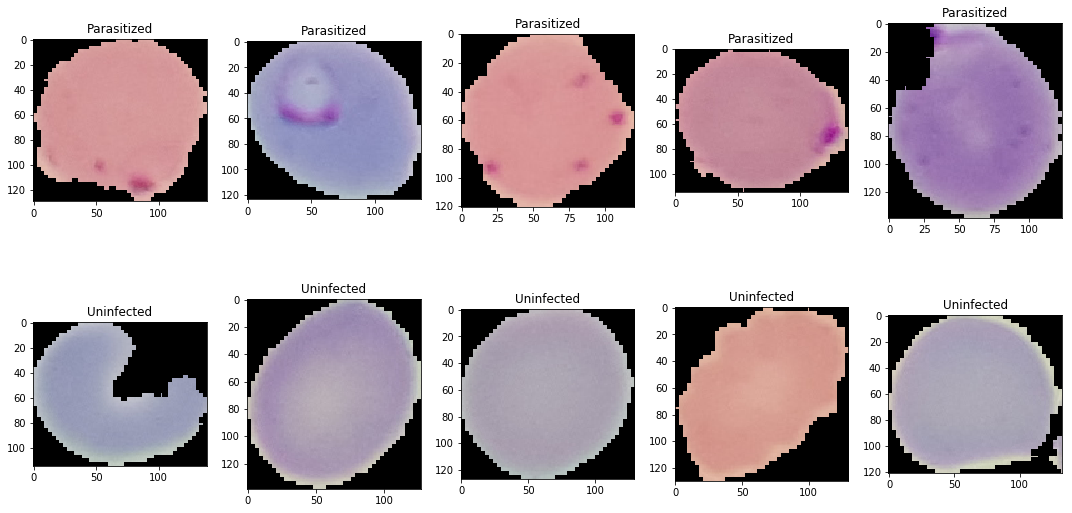

In [13]:
import matplotlib.pyplot as plt
from numpy.random import randint
%matplotlib inline

fig,axes = plt.subplots(nrows=2,ncols=5,figsize=(15,8))

# Show 5 random images from Parasitized dataset
for i,img in enumerate(randint(0,len(parasitized_data)-1,size=5)):
    axes[0,i].imshow(imread(parasitized_path+parasitized_data[img]))
    axes[0,i].set_title('Parasitized')

# Show 5 random images from Uninfected dataset
for i,img in enumerate(randint(0,len(uninfected_data)-1,size=5)):
    axes[1,i].imshow(imread(uninfected_path+uninfected_data[img]))
    axes[1,i].set_title('Uninfected')
    
plt.tight_layout()

The images clearly show there are discernible differences between the images in each class – this is good, and suggests that we should be able to achieve accurate end results if we build an appropriate CNN.

We can also notice that the images vary in size and, therefore, will require some preprocessing before being used as input data for the neural network. <br><br>

## 2. Data pre-processing

For the purposes of this project, namely due to the processing power available (no GPU), I will use an image size of 50x50 pixels. For some image classification problems, scaling the images down significantly can have a detrimental effect on the ability of the CNN to distinguish features consequently a poor performance is realised. 

However, for this project it can be observed that the images are already of relatively low resolution and do contain particularly detailed features (e.g. sharp edges) and, therefore, it is envisaged that rescaling the data to 50x50 images will have little effect on the CNN performance. Particarly during the development of the CNN, it can be advantageous to use a smaller image size to reduce training times - the resolution can then be increased at a later stage, if it is felt that this will improve the performance.
<br><br>

In [14]:
import numpy as np
from skimage.transform import resize

# Define a constant image size for all images
IMAGE_SIZE = (50,50)

# Loop through the images in each folder, resize and append to a list containing all the data.
all_data = []
all_labels = []

for img in parasitized_data:
    try:
        image = imread(parasitized_path + '/' + img)
        image = resize(image,IMAGE_SIZE)
        all_data.append(image)
        all_labels.append(1)
    except:
        None
        
for img in uninfected_data:
    try:
        image = imread(uninfected_path + '/' + img)
        image = resize(image,IMAGE_SIZE)
        all_data.append(image)
        all_labels.append(0)
    except:
        None
    

# Convert to a Numpy array
X = np.array(all_data)
y = np.array(all_labels)

We must now split the dataset for training the CNN. We will use the using Scikit learn *train_test_split* function to do so. As previously discussed, we require teh data to be split into 3 sets:
- __Training set__ for training the CNN and adjusting the update weights during the back-propagation step;
- __Validation set__ to assess the CNN performance and to indicate changes required to the architecture to improve results e.g under/overfitting;
- __Test set__ to test the model on a completely new test set and verify the performance.

In [15]:
from sklearn.model_selection import train_test_split

# First, we split the data into a training and validation test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

# We then split the validation set again into the final validation set and the test set
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.25, random_state=42)

print('Number of images in training set: ' + str(len(X_train)))
print('Number of images in validation set: ' + str(len(X_val)))
print('Number of images in test set: ' + str(len(X_test)))

# Confirm that the training and validation datasets are well balanced (~50% of each class)
print('\nPercentage of Parasitized images in training set: ' + str(100*sum(y_train)/len(y_train)) + '%')
print('Percentage of Parasitized images in training set: ' + str(100*sum(y_test)/len(y_test)) + '%')

Number of images in training set: 16509
Number of images in validation set: 8255
Number of images in test set: 2752

Percentage of Parasitized images in training set: 49.95457023441759%
Percentage of Parasitized images in training set: 48.7281976744186%


<br>
In order to prevent overfitting and to allow for the CNN to generalise more effectively, we will use data augmentation. That is, each image will be randomly transformed (e.g. sheared/flipped/shifted) during the training such that the CNN never sees the exact same image. This technique can be particularly useful when using a small dataset to train a network. Here we will use the Keras *ImageDataGenerator* apply our augmentation. It should be noted that we only want to apply image transformations to the training set; the validation set should only be rescaled to normalise the data.
<br><br>

In [134]:
from keras.preprocessing.image import ImageDataGenerator


# Instantiate the generators for the training and validation sets. 
# Note that only rescaling is applied to the validation dataset.
training_data_generator = ImageDataGenerator(rescale=1./255,
                                             shear_range=0.2,
                                             horizontal_flip=True,
                                             vertical_flip=True)

validation_data_generator = ImageDataGenerator(rescale=1./255)

# Set the batch size as a hyper-parameter
BATCH_SIZE = 32

# Flow the data augmentation onto the images
training_set = training_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_set = validation_data_generator.flow(X_test, y_test, batch_size=BATCH_SIZE)


## 3. Building a Convolutional Neural Network (CNN)

We are now ready to build a CNN to attempt to classify the images. There is no 'one-size fits all' approach to building an effective CNN - however it is good practice to start with a simple architecture and iteratively alter the model according the results.
<br><br>
Here we will start with a very simple model consisting of a single convolutional layer and a single fully-connected layer with 16 nodes:

In [1]:
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import CSVLogger
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [5]:
# Define some hyper-parameters
INPUT_SHAPE = (IMAGE_SIZE[0],IMAGE_SIZE[1],3)
EPOCHS = 20

In [36]:
classifier_1 = Sequential()

classifier_1.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
classifier_1.add(Activation("relu"))
classifier_1.add(MaxPooling2D(pool_size=(2, 2)))

classifier_1.add(Flatten())
classifier_1.add(Dense(16))
classifier_1.add(Activation("relu"))
classifier_1.add(Dropout(0.5))
classifier_1.add(Dense(1))
classifier_1.add(Activation("sigmoid"))

classifier_1.compile(loss="binary_crossentropy",
              optimizer=RMSprop(),
              metrics=["accuracy"])

In [37]:
classifier_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                294928    
_________________________________________________________________
activation_5 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
__________

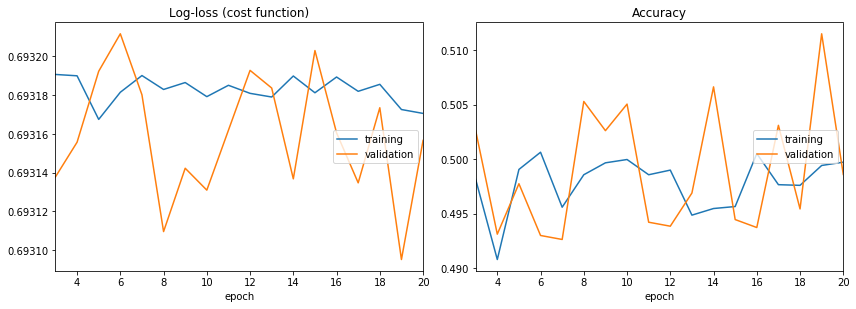

Log-loss (cost function):
training   (min:    0.693, max:    0.693, cur:    0.693)
validation (min:    0.693, max:    0.693, cur:    0.693)

Accuracy:
training   (min:    0.491, max:    0.501, cur:    0.500)
validation (min:    0.493, max:    0.511, cur:    0.499)


In [31]:
# Training
classifier_1.fit_generator(training_set,
                           steps_per_epoch=len(y_train) // BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=validation_set,
                           validation_steps=len(y_test) // BATCH_SIZE,
                           callbacks=[PlotLossesKeras(),CSVLogger('classifier_1.csv',append=False,separator=";")], 
                           verbose=1)


classifier_1.save_weights('classifier_1.h5')

<br>
It is clear from these results that the model isn't training correctly! The loss functions aren't decreasing with each epoch and the accuracy is fluctating around 50% (this suggests that the CNN isn't learning at all, and is effectively guessing the class, meaning it gets it right half of the time). 
<br><br>
We will try using the same model again, however using a slower learning rate to see if this helps. The learning rate refers to how significantly the model updates the weights in response to the loss function. If the rate is too small, the model will take many epochs to converge and may get stuck in a local minima. On the other hand, if the learning rate is too large (as suspected in the previous run), the model may miss the minima and act and choose entirely sub-optimal weights.
<br><br>

In [20]:
classifier_2 = Sequential()

classifier_2.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
classifier_2.add(Activation("relu"))
classifier_2.add(MaxPooling2D(pool_size=(2, 2)))

classifier_2.add(Flatten())
classifier_2.add(Dense(16))
classifier_2.add(Activation("relu"))
classifier_2.add(Dropout(0.5))
classifier_2.add(Dense(1))
classifier_2.add(Activation("sigmoid"))

classifier_2.compile(loss="binary_crossentropy",
              optimizer=RMSprop(lr=0.0001),
              metrics=["accuracy"])

In [14]:
classifier_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                294928    
_________________________________________________________________
activation_8 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
__________

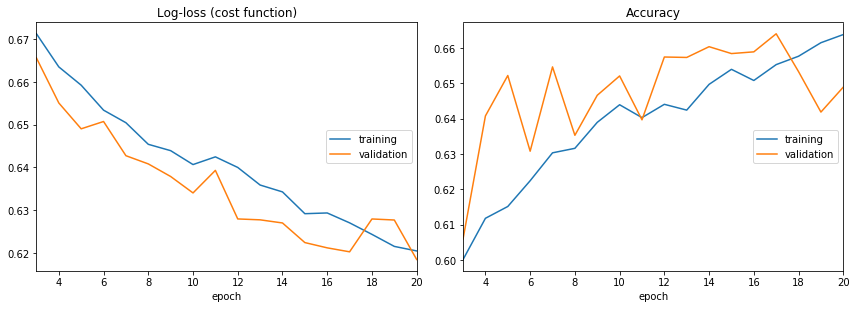

Log-loss (cost function):
training   (min:    0.620, max:    0.691, cur:    0.620)
validation (min:    0.618, max:    0.686, cur:    0.618)

Accuracy:
training   (min:    0.540, max:    0.664, cur:    0.664)
validation (min:    0.597, max:    0.664, cur:    0.649)


In [27]:
# Training
classifier_2.fit_generator(training_set,
                           steps_per_epoch=len(y_train) // BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=validation_set,
                           validation_steps=len(y_test) // BATCH_SIZE,
                           callbacks=[PlotLossesKeras(),CSVLogger('classifier_2.csv',append=False,separator=";")], 
                           verbose=1)


classifier_2.save_weights('classifier_2.h5')

<br>
Great! Lowering the learning rate seems to have worked, in that the model is now improving as the number of epochs increases (i.e. it is no longer just guessing). We end up with a validation accuracy of ~65%, meaning we are getting 2 out of 3 predictions correct. Not bad, however it is likely this can be improved significantly - remember that the CNN is currently very simple. We can also see the the Log-loss function for the validation is lower than the training set through the model training - this is a key indicator that our model is underfitted.
<br><br>
We will add 3 more higher-level convolutional layers (64,128 and 256 filters) and increase the number of neurons in the fully connected layer from 16 to 256. Note that whilst this will (hopefully) improve the model performance, training will take significantly longer, due to the massive increase in the number of weights to be calculated. 
<br><br>

In [22]:
classifier_3 = Sequential()

classifier_3.add(Conv2D(32, (3, 3), input_shape = INPUT_SHAPE))
classifier_3.add(Activation("relu"))
classifier_3.add(MaxPooling2D(pool_size=(2, 2)))
classifier_3.add(Dropout(0.3))

classifier_3.add(Conv2D(64, (3, 3)))
classifier_3.add(Activation("relu"))
classifier_3.add(MaxPooling2D(pool_size=(2, 2)))
classifier_3.add(Dropout(0.3))

classifier_3.add(Conv2D(128, (3, 3)))
classifier_3.add(Activation("relu"))
classifier_3.add(MaxPooling2D(pool_size=(2, 2)))
classifier_3.add(Dropout(0.3))

classifier_3.add(Conv2D(256, (3, 3)))
classifier_3.add(Activation("relu"))
classifier_3.add(MaxPooling2D(pool_size=(2, 2)))
classifier_3.add(Dropout(0.3))

classifier_3.add(Flatten())

classifier_3.add(Dense(256))
classifier_3.add(Activation("relu"))
classifier_3.add(Dropout(0.5))

classifier_3.add(Dense(1))
classifier_3.add(Activation("sigmoid"))

classifier_3.compile(loss="binary_crossentropy",
              optimizer=RMSprop(lr=0.0001),
              metrics=["accuracy"])

In [23]:
classifier_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
activation_22 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
activation_23 (Activation)   (None, 22, 22, 64)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 11, 11, 64)        0         
__________

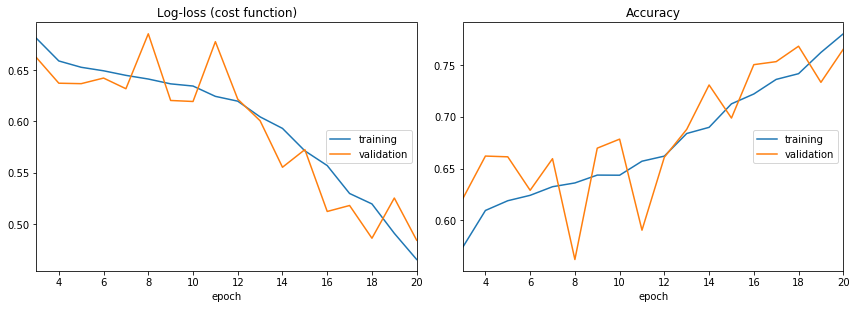

Log-loss (cost function):
training   (min:    0.465, max:    0.693, cur:    0.465)
validation (min:    0.484, max:    0.694, cur:    0.484)

Accuracy:
training   (min:    0.500, max:    0.780, cur:    0.780)
validation (min:    0.487, max:    0.768, cur:    0.765)


In [24]:
# Training
classifier_3.fit_generator(training_set,
                           steps_per_epoch=len(y_train) // BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=validation_set,
                           validation_steps=len(y_test) // BATCH_SIZE,
                           callbacks=[PlotLossesKeras(),CSVLogger('classifier_3.csv',append=False,separator=";")], 
                           verbose=1)


classifier_3.save_weights('classifier_3.h5')

<br>
We can see from this that the losses seem to match better for the training and validation sets; this suggests we are no longer underfitting. However, we can clearly see that the accuracy CNN was only increasing slowly with each epoch and has not converged. This leaves us 3 options. <br>

__1. Increase the learning rate:__ However this seemed to be causing the problem earlier and so is not a sensible option!<br>

__2. Increase the number of epochs:__ This will give the model more time to converge. By lowering the learning rate earlier, we can expect that convergence will be slower; however by significantly increasing the number of epochs, we will greatly increase the time required to train the model.

__3. Add batch normalization to the convolutional layers:__ This is a trick which can be used to speed up the training of networks with higher learning rates. This works by normalizing the batch by mean and variance before we call the activation function. Further information on using batch normalization can be found here: https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/<br>

We will take the third option to see if we can successfully train the model without having to drastically increase the number epochs. We will, however, increase the number of epochs form 20 to 25, to allow a little longer for convergence.<br><br>

In [135]:
classifier_4 = Sequential()

classifier_4.add(Conv2D(32, (3, 3), use_bias = False, input_shape = INPUT_SHAPE))
classifier_4.add(BatchNormalization())
classifier_4.add(Activation("relu"))
classifier_4.add(MaxPooling2D(pool_size=(2, 2)))
classifier_4.add(Dropout(0.3))

classifier_4.add(Conv2D(64, (3, 3), use_bias = False))
classifier_4.add(BatchNormalization())
classifier_4.add(Activation("relu"))
classifier_4.add(MaxPooling2D(pool_size=(2, 2)))
classifier_4.add(Dropout(0.3))

classifier_4.add(Conv2D(128, (3, 3), use_bias = False))
classifier_4.add(BatchNormalization())
classifier_4.add(Activation("relu"))
classifier_4.add(MaxPooling2D(pool_size=(2, 2)))
classifier_4.add(Dropout(0.3))

classifier_4.add(Conv2D(256, (3, 3), use_bias = False))
classifier_4.add(BatchNormalization())
classifier_4.add(Activation("relu"))
classifier_4.add(MaxPooling2D(pool_size=(2, 2)))
classifier_4.add(Dropout(0.3))

classifier_4.add(Flatten())

classifier_4.add(Dense(256))
classifier_4.add(Activation("relu"))
classifier_4.add(Dropout(0.5))

classifier_4.add(Dense(1))
classifier_4.add(Activation("sigmoid"))

classifier_4.compile(loss="binary_crossentropy",
              optimizer=RMSprop(lr=0.0001),
              metrics=["accuracy"])

In [7]:
classifier_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18432     
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 22, 64)        256       
__________

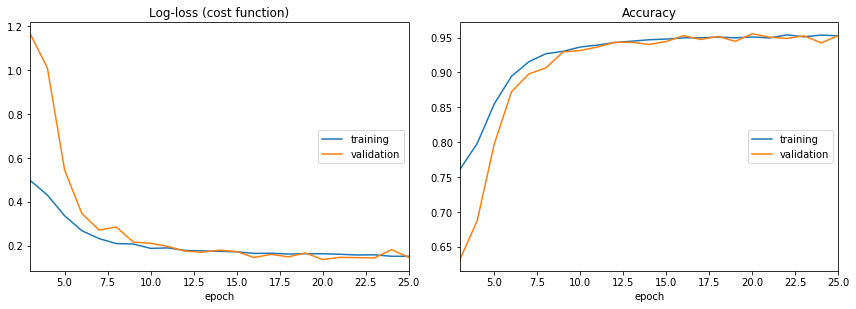

Log-loss (cost function):
training   (min:    0.152, max:    0.766, cur:    0.152)
validation (min:    0.137, max:    1.206, cur:    0.147)

Accuracy:
training   (min:    0.612, max:    0.954, cur:    0.953)
validation (min:    0.555, max:    0.955, cur:    0.953)


In [42]:
# Training
EPOCHS = 25

classifier_4.fit_generator(training_set,
                           steps_per_epoch=len(y_train) // BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=validation_set,
                           validation_steps=len(y_test) // BATCH_SIZE,
                           callbacks=[PlotLossesKeras(),CSVLogger('classifier_4.csv',append=False,separator=";")], 
                           verbose=1)


classifier_4.save_weights('classifier_4.h5')

<br>
This is a great result - we have achieved an impressive accuracy of over 95%! The batch normalisation seems to have worked very effectively, such that the model had converged at ~10 epochs. We can also see from the Log-loss funciton and the Accuracy plot that once converged, the training set and validation set are very well matched; this suggest that our model is neither underfitted nor overfitted.<br><br>

## 4.	Final Testing

We now have a model which seems to be working very well and to a high accuracy. To further validate the results, we will test the model on a wholly separate dataset, which has not been used during the training and/or refinement of the CNN architecture.

In [119]:
# Instantiate the test set generator. Note that only rescaling is required for the test dataset.
test_data_generator = ImageDataGenerator(rescale=1./255)

# Flow the data augmentation onto the images
test_set = validation_data_generator.flow(X_test,batch_size=1,shuffle=False)

In [120]:
# Perform the predictions
predictions = classifier_4.predict_generator(test_set,steps=len(y_test))

In [129]:
# Use a threshold of 0.5 to split predictions into 'Uninfected' and 'Parasitized' classes
pred_classes = list(map(lambda c: c > 0.5, list(predictions[:,0])))

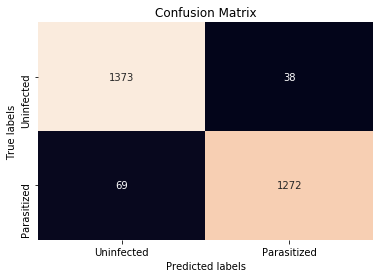

In [131]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

# Determine the confusion matrix
cm = confusion_matrix(y_test,pred_classes)

# Plot the confusion matrix
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d",annot_kws={"fontsize":10},cbar=False);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Uninfected', 'Parasitized']); ax.yaxis.set_ticklabels(['Uninfected', 'Parasitized']);

In [132]:
#Print the classification report
print(classification_report(y_test,pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1411
           1       0.97      0.95      0.96      1341

   micro avg       0.96      0.96      0.96      2752
   macro avg       0.96      0.96      0.96      2752
weighted avg       0.96      0.96      0.96      2752



<br>
We can see that the precision matches the accuracy we were achieving during the training of the CNN - this is good new and suggests that our model is well fit. Let's also plot a few examples from the test set:<br><br>

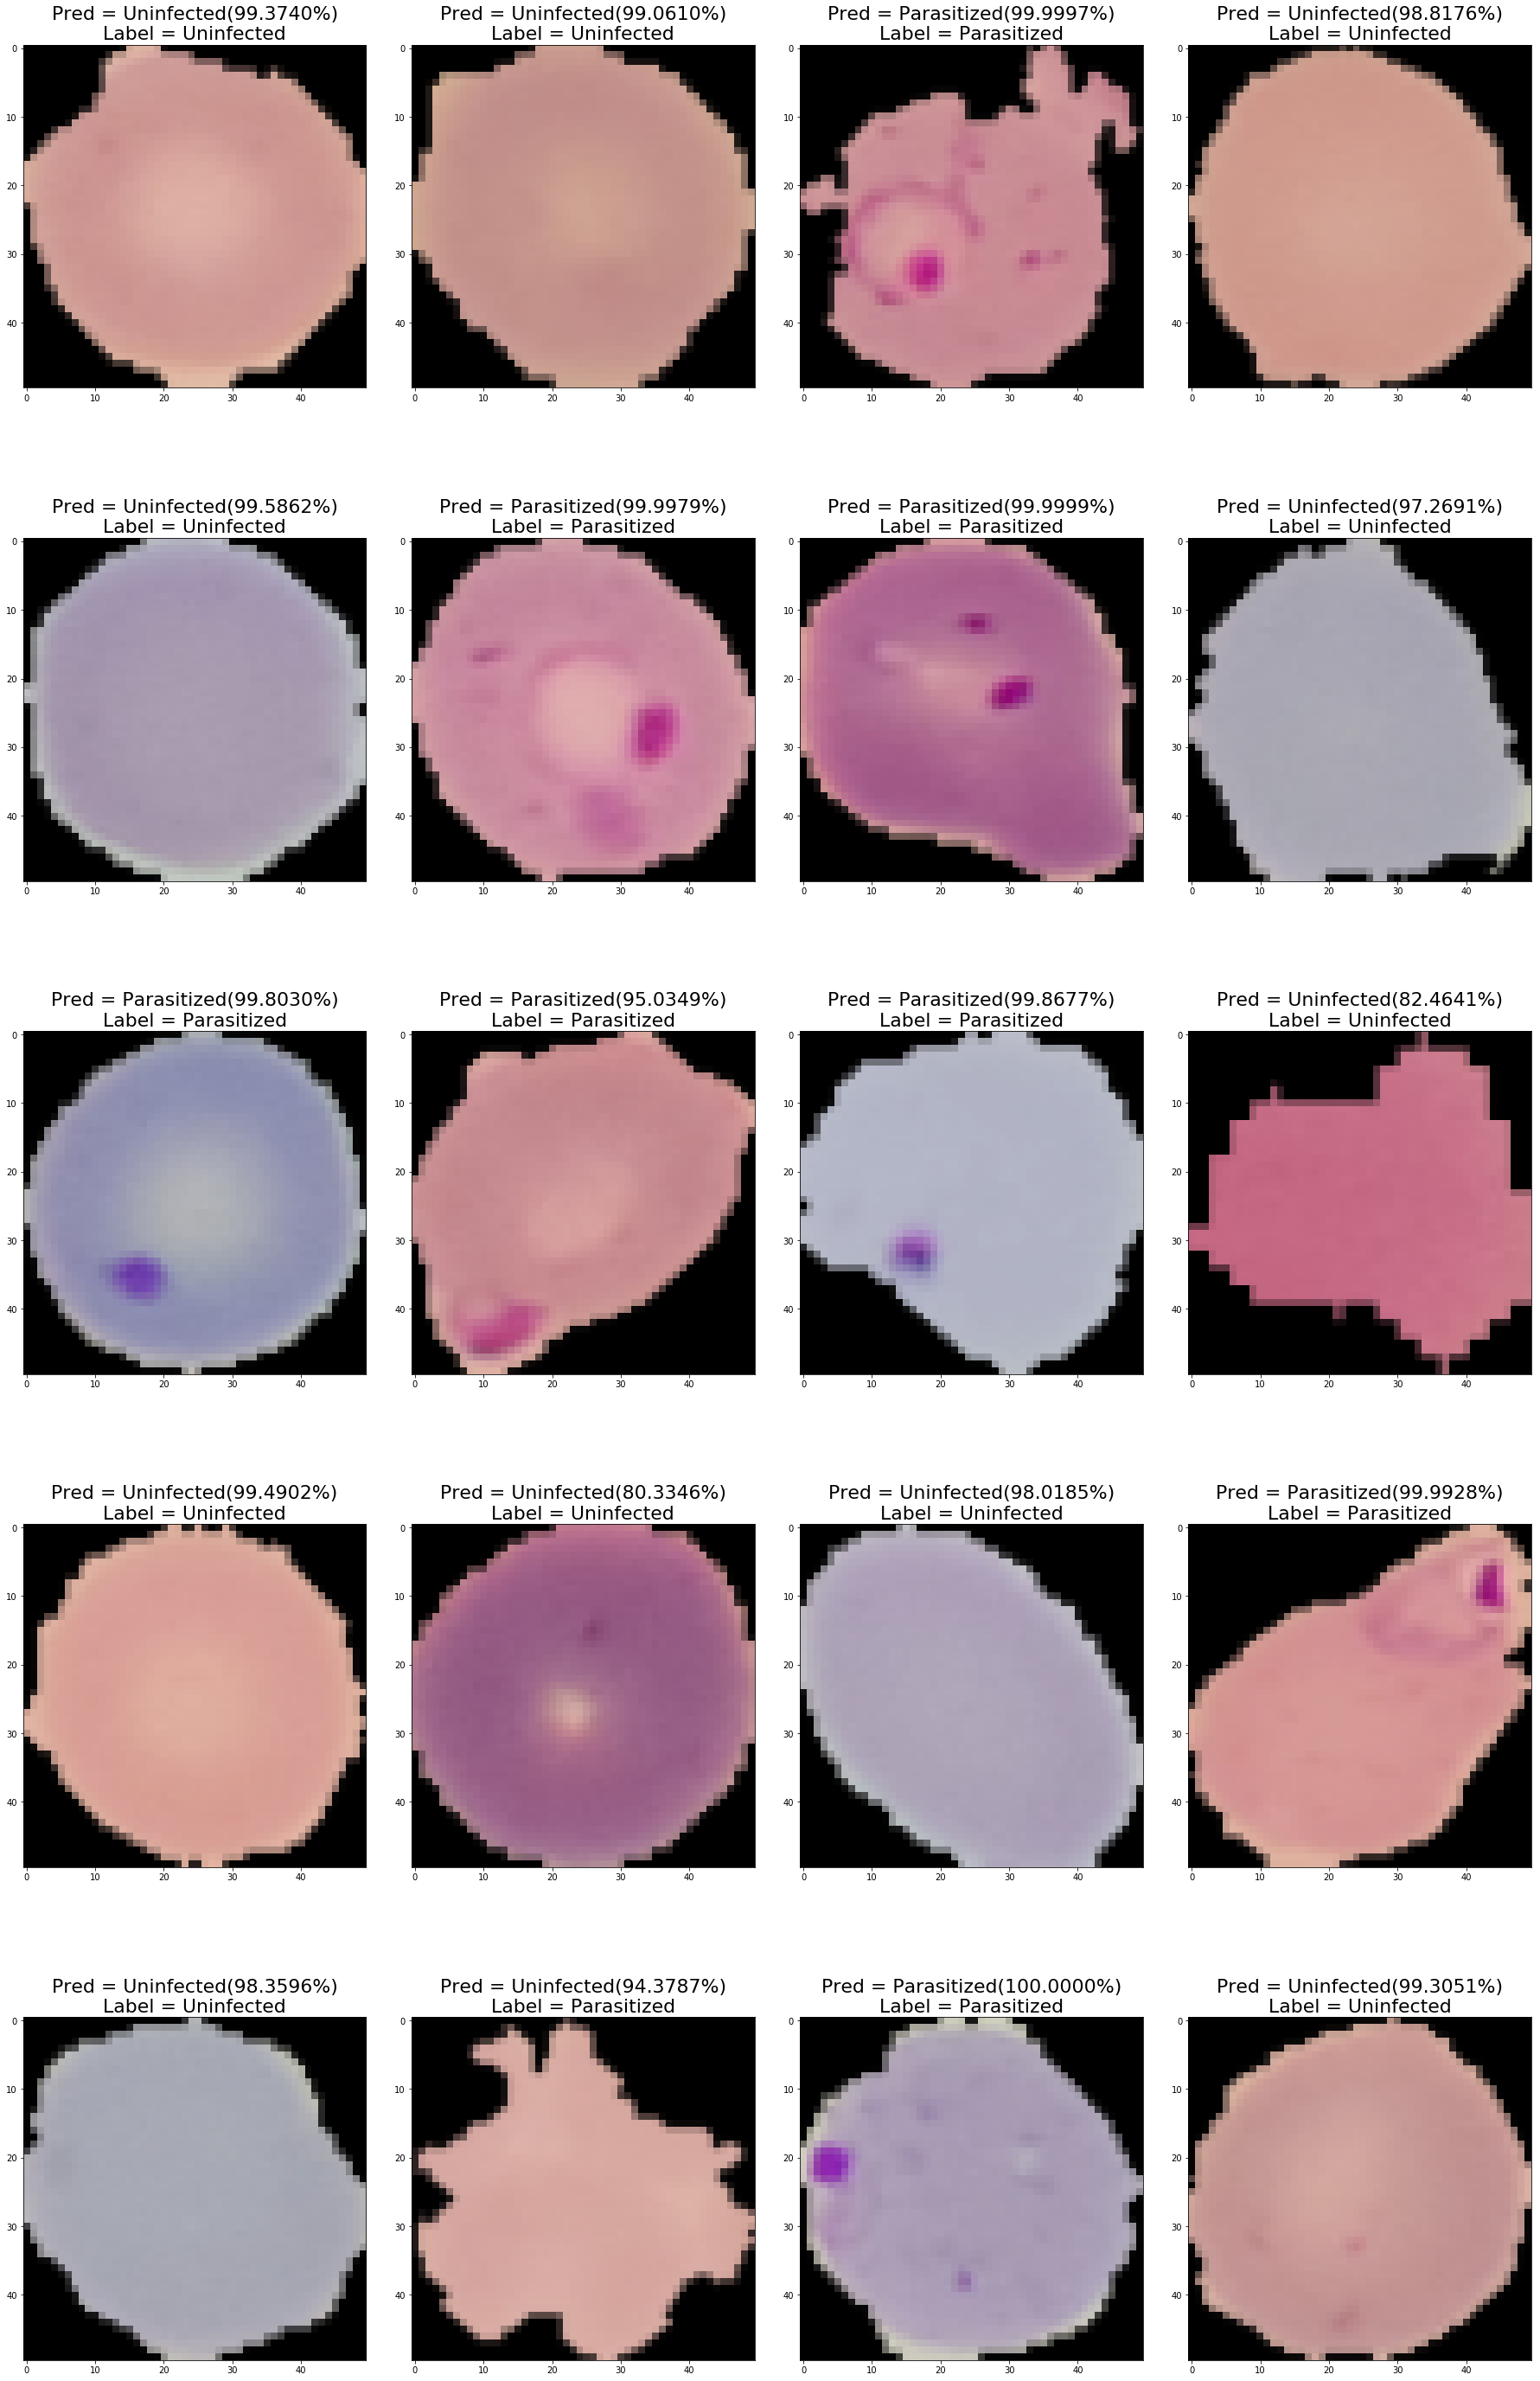

In [118]:
y_test_labels = ['Parasitized' if label else 'Uninfected' for label in y_test]

fig,axes = plt.subplots(nrows=5,ncols=4,figsize=(25,40))
axes = axes.reshape(-1)
for i,img in enumerate(randint(0,len(X_test)-1,size=20)):
    axes[i].imshow((X_test[img]))
    if predictions[img] > 0.5:
        title_str = f'Pred = Parasitized({100*predictions[img,0]:.4f}%)\nLabel = ' + y_test_labels[img]
        axes[i].set_title(title_str,fontsize=22)
        
    else:
        title_str = f'Pred = Uninfected({100*(1-predictions[img,0]):.4f}%)\nLabel = ' + y_test_labels[img]
        axes[i].set_title(title_str,fontsize=22)
  
plt.tight_layout()

<br>
It's all looking good at this point, however we can further improve the model. We can tweak the predicted classifications by varying the probability threshold at which we conclude that the cell is either Uninfected or Parasitized. At the moment, we have used a threshold of 0.5 - any value predicted by our CNN under this is classed at Uninfected, and anything over 0.5 is classed as Parasitized.<br>

Given the application of this image classifier, we are actually less interested in the overall accuracy of the model, and more so by the recall values. That is, it is important to **reduce the number of False Negatives** (where we predict that the cell is Uninfected, when in fact it is Parasitized). This may result in a greater number of False Positives (where we predict a cell is Parasitized, when in fact it is Uninfected), however in a medical context this is far less significant!<br><br>

/Users/Sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars


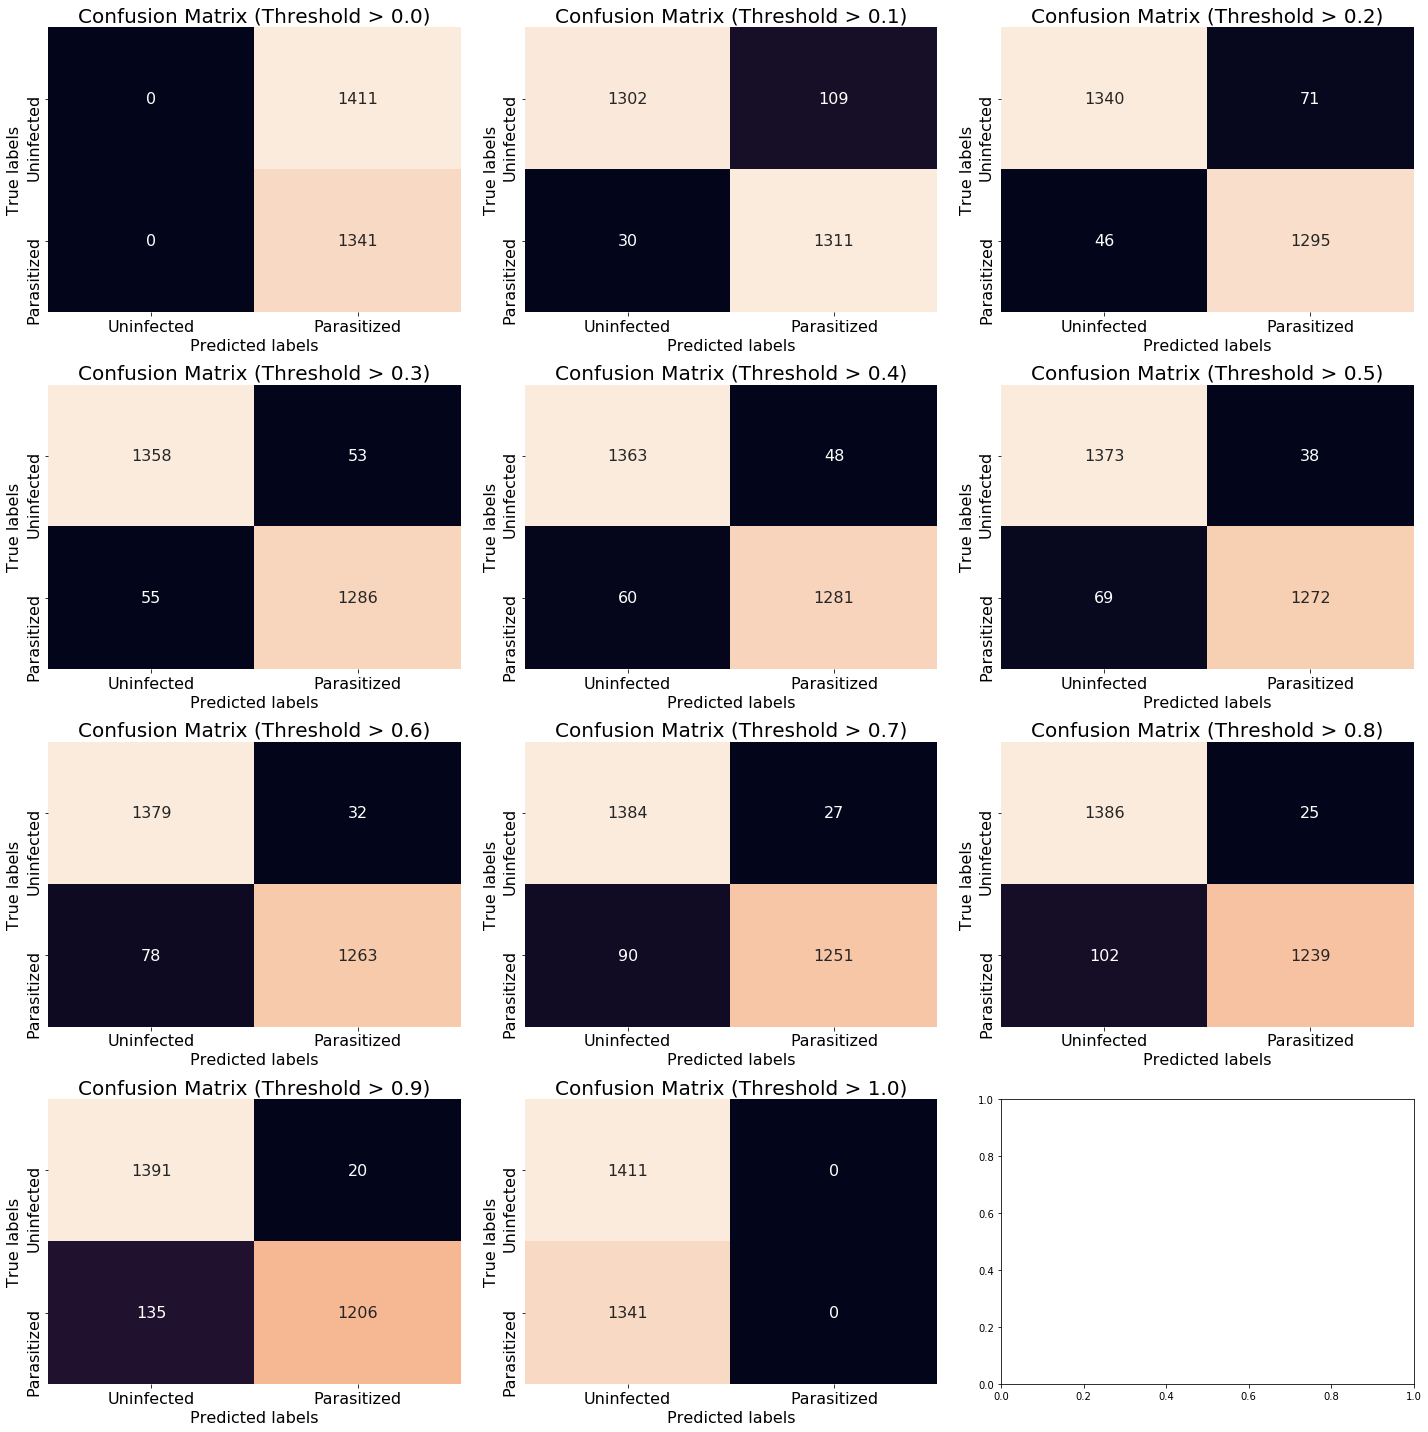

In [89]:
fig,axes = plt.subplots(nrows=4,ncols=3,figsize=(20,20))
axes = axes.reshape(-1)

threshold_list = np.linspace(0,1,21)
recall_vals = []
accuracy_vals = []
ax = 0

for i,threshold in enumerate(threshold_list):
 
    pred_classes = list(map(lambda c: c > threshold, list(predictions[:,0])))

    # Determine the confusion matrix
    cm = confusion_matrix(y_test,pred_classes)

    # Plot the confusion matrix
    if i%2 == 0:
        sns.heatmap(cm, annot=True, ax = axes[ax],fmt="d",annot_kws={"fontsize":16},cbar=False);

        axes[ax].set_xlabel('Predicted labels',fontsize=16);axes[ax].set_ylabel('True labels',fontsize=16); 
        axes[ax].set_title('Confusion Matrix (Threshold > '+str(round(threshold,2))+')',fontsize=20); 
        axes[ax].xaxis.set_ticklabels(['Uninfected', 'Parasitized'],fontsize=16); axes[ax].yaxis.set_ticklabels(['Uninfected', 'Parasitized'],fontsize=16);       
        ax += 1
        
    recall_vals.append(cm[1,1]/(cm[1,0]+cm[1,1]))
    accuracy_vals.append(cm[1,1]/(cm[0,1]+cm[1,1]))
    
plt.tight_layout()

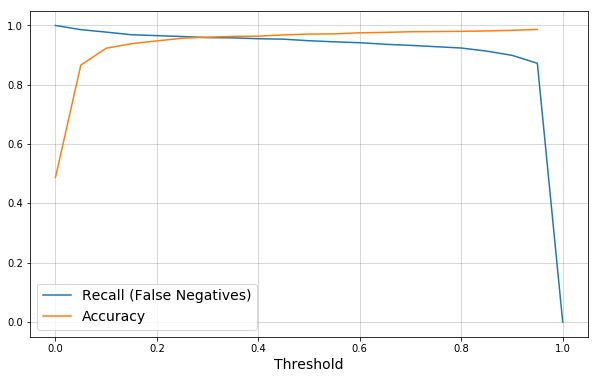

In [133]:
#Plot the accuracy and recall values as a function of threshold
fig = plt.figure(figsize=(10,6))

plt.plot(threshold_list,recall_vals,label='Recall (False Negatives)')
plt.plot(threshold_list,accuracy_vals,label='Accuracy')

plt.grid(color='k', linestyle='-', linewidth=0.5,alpha=0.3)
plt.xlabel('Threshold',fontsize=14)
plt.legend(fontsize=14)

<br>
As an observation, it is noticable from the confusion matrices and the plot above that the change in recall value is relatively small as we adjust the threshold. This suggests that the prediction values from the CNN lie at the extremes (either very close to 0 or very close to 1, and not much in the middle!).

It is now up to the user to decide the optimal operating point. As stated earlier, given the medical context of this problem, it is critical to maximise the recall value (i.e. reduce the number of false negatives). From the graph, we can see that this favours selecting a low threshold value, however this comes at the cost of reducing the accuracy (how many of the cells we predicted were Parasitized **actually** are Parasitized). To a certain extent, a lower accuracy is not a huge problem; we would rather catch more cases of Parasitized cells than raise a few false alarms. However, when we take this to the limit, if we make the threshold too low, we predict all cells as Parasitized and the CNN is effectively redundant.

Therefore, a 'sweet spot' should be selected which provides a high enough recall rate, whilst raising an acceptable number of false alarms. From the evidence above, a **threshold = 0.2** seems a good balance, giving final values of:

- __Recall = 97%__
- __Accuracy = 95%__<br><br>

## Further Work

Despite the high accuracy and recall values obtained here, there is a chance we can futher improve the results. Possible future invesitgations include:

- __GridSearchCV:__ To optimise the hyper-parameters (e.g. batch size, number of epochs, optimiser). <br><br>
- __Increasing the image resolution:__ Due to the computing power available, the images were downsized to 50x50. given more power (e.g. a GPU), the image resolution could be increased to assess if this has any effect.<br><br>